## 3.1. Setup

### Import Libraries

In [1]:
# Basic imports
import os
import sys
sys.path.append('..')

from typing import Optional, Dict, Any
import warnings
warnings.filterwarnings("ignore") # ignore all warnings
import logging
logging.basicConfig(level = logging.CRITICAL)

# Import Google ADK
from google.adk.agents import Agent # Agent class
from google.adk.models.lite_llm import LiteLlm # for Open AI Support
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types # for creating message Content/Parts

print("Libraries imported.")


Libraries imported.


### Define the Models

In [2]:
MODEL_GPT = 'openai/gpt-4o'

llm = LiteLlm(model = MODEL_GPT)

# Test LLM with a direct call
print(
    llm.llm_client.completion(
        model = llm.model,
        messages = [
            {
                "role": "user",
                "content":"Are you ready?"
            }
        ],
        tools = []
    )
)

print("\n LLM is ready to use")

ModelResponse(id='chatcmpl-CDGrve0YD7YI8o6dnMIr7NkOhd9ue', created=1757279143, model='gpt-4o-2024-08-06', object='chat.completion', system_fingerprint='fp_cbf1785567', choices=[Choices(finish_reason='stop', index=0, message=Message(content="Yes, I'm ready! How can I assist you today?", role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]), provider_specific_fields={})], usage=Usage(completion_tokens=13, prompt_tokens=27, total_tokens=40, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None)), service_tier='default')

 LLM is ready to use


## 3.2. Explore neo4j_for_adk

In [3]:
from helpers.neo4j_for_adk import graphdb

graphdb has a method send_query which expects a cypher query, runs the query and then formats the results as follows:

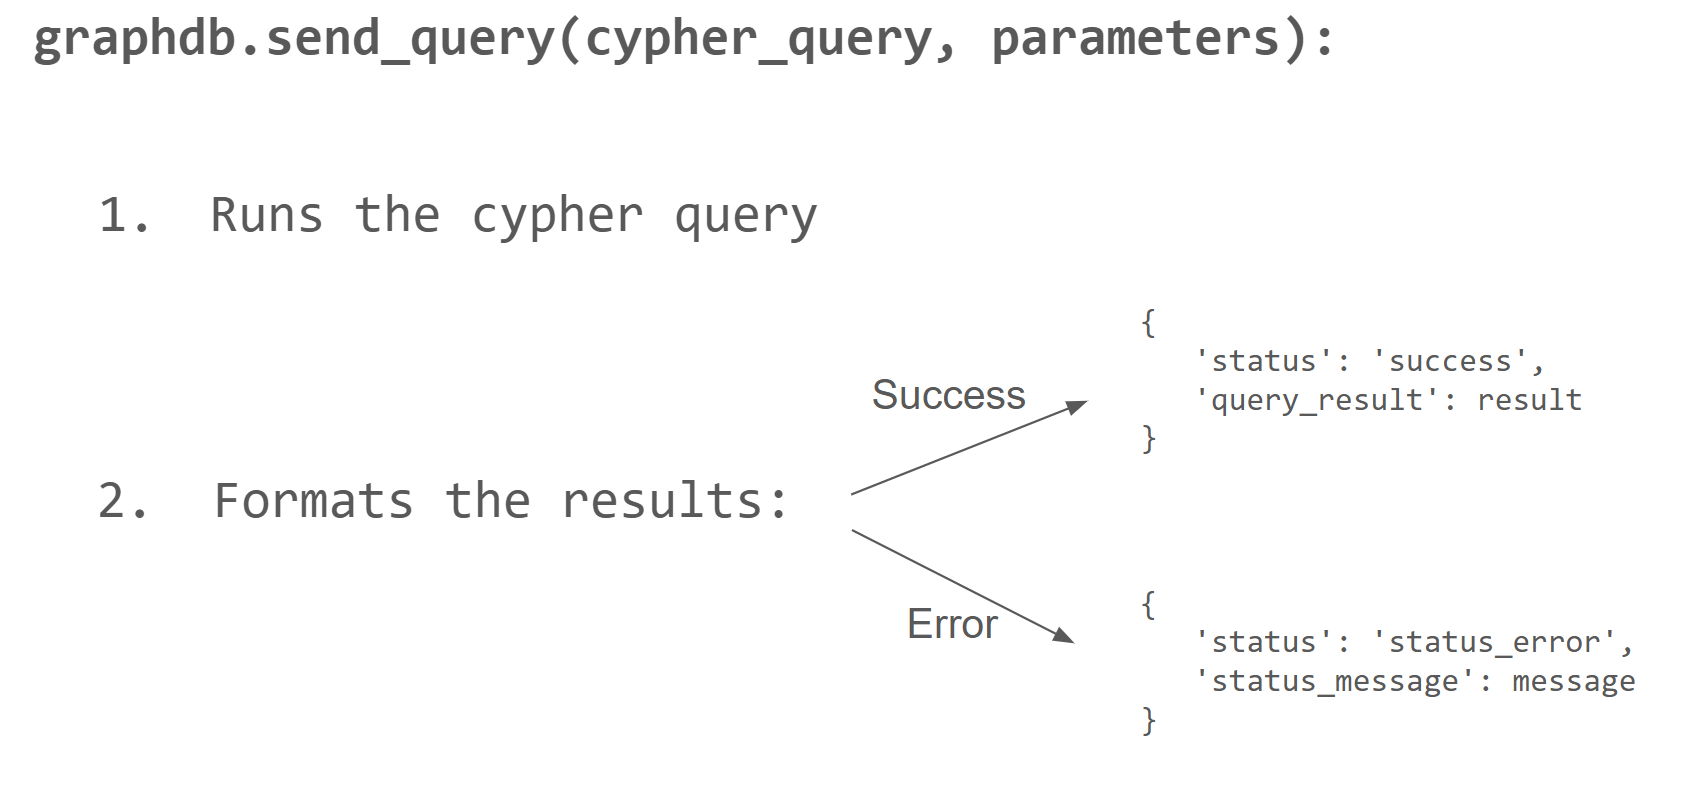

In [4]:
# Sending a simple query to the database
neo4j_is_ready = graphdb.send_query("RETURN 'Neo4j is Ready!' as message")

print(neo4j_is_ready)

{'status': 'success', 'query_result': [{'message': 'Neo4j is Ready!'}]}


## 3.3. Define Agent's Tool

In [5]:
# Defining a basic tool -- send a parameterized cypher query
def say_hello(person_name:str) -> dict:
    """
    Formats a welcome message to a named person
    Args:
        person_name (str): The name of the person you are saying hello to
    Returns:
        dict: A dictionary containing the results of the query.
              Includes a 'status' key ('success' or 'error')
              If 'success', includes a 'query_result' key with an array of results'
              If 'error', includes an 'error_message' key
    """
    return graphdb.send_query(
        "RETURN 'Hello to you, ' + $person_name AS reply",
        {
            "person_name":person_name
        }
    )

In [6]:
# Example tool usage (optional test)
print(say_hello("Akash"))

{'status': 'success', 'query_result': [{'reply': 'Hello to you, Akash'}]}


## 3.4. Defining the Agent - 'friendly cypher agent'

**Optional Reading**

- An `Agent` in Google ADK orchestrates the interaction between the user, the LLM, and the available tools

- you configure it with several key parameters:
    * `name`: A unique identifier for this agent (e.g., "friendly_cypher_agent\_v1").  
    * `model`: Specifies which LLM to use. you'll use the `llm` variable we defined above.  
    * `description`: A summary of the agent's overall purpose. This is like public documentation that helps other agents decide when to delegate tasks to *this* agent.  
    * `instruction`: Detailed guidance given to the LLM on how this agent should behave, its persona, goals, and specifically *how and when* to utilize its assigned `tools`.  
    * `tools`: A list containing the actual Python tool functions the agent is allowed to use (e.g., `[say_hello]`).

**Best Practice:** 
- Provide clear and specific `instruction` prompts. The more detailed the instructions, the better the LLM can understand its role and how to use its tools effectively. Be explicit about error handling if needed.
- Choose descriptive `name` and `description` values. These are used internally by ADK and are vital for features like automatic delegation (covered later).

In [7]:
hello_agent = Agent(
    name = "hello_agent_v1",
    model = llm, # defined earlier as open ai
    description = "Has friendly chats with a user", # Very important for ADK to understand agent purpose
    instruction = """
    You are a helpful assistant, chatting with a user.
    Be polite and friendly, introducing yourself and asking who the user is.

    If the user provides their names, use the 'say_hello' tool to get a custom greeting.
    If the tool returns an error, inform the user politely.
    If the tool is successful, present the reply.
    """,
    tools=[say_hello], # pass the tool/function directly
)

print(f"Agent '{hello_agent.name}' created.")

Agent 'hello_agent_v1' created.


## 3.5. Run the Agent

### 3.5.1 Event Loop

<img src="../images/event_loop_3.png"  alt="diagram of Agent Development Kit runtime showing the Runner component handling an Event Loop with Services for the User" width=400> 

The [ADK Runtime](https://google.github.io/adk-docs/runtime/) orchestrates agents throughout execution. 
- The main component is an event-driven loop intermediated by a Runner. When the runner receives a user query, it asks the agent to start processing. 
- The agent processes the query and emits an event. 
- The Runner receives the event, records state changes, updates memory and forwards the event to the user interface. 
- After that, the agent's logic resumes and the cycle repeats until no further events are produced by the agent and the user has a response.


### 3.5.2. Create the Runner and Session Service

In [8]:
app_name = hello_agent.name + "_app"
user_id = hello_agent.name + "_user"
session_id = hello_agent.name + "_session_01"

# Initialize a session service and a session
session_service = InMemorySessionService()
await session_service.create_session(
    app_name = app_name,
    user_id = user_id,
    session_id = session_id
)

runner = Runner(
    agent = hello_agent,
    app_name = app_name,
    session_service = session_service
)

### 3.5.3. Run the Agent



Here's what's happening:
 
1. Package the user query into the ADK `Content` format.
2. Call`runner.run_async` (providing it with user/session context and the new message)
4. Iterate through the **Events** yielded by the runner. Events represent steps in the agent's execution (e.g., tool call requested, tool result received, intermediate LLM thought, final response).  
5. Identify and print the **final response** event using `event.is_final_response()`.

**Why `async`?** Interactions with LLMs and potentially tools (like external APIs) are I/O-bound operations. Using `asyncio` allows the program to handle these operations efficiently without blocking execution.

In [9]:
user_message = "Hello, I am Akash"
print(f"\n>>> User Message: {user_message}")

# Prepare the User's message in google ADK Format
content = types.Content(
    role = "user",
    parts = [types.Part(text = user_message)]
)

final_response_text = "Agent did not produce a final response." # Default will be replaced if the agent produces a final response.


>>> User Message: Hello, I am Akash


In [10]:
# Iterate through the events to find the final answer
verbose = False

async for event in runner.run_async(user_id = user_id, session_id = session_id, new_message = content):
    if verbose:
        print(f"[Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")
    
    # Key Concept: is_final_response() marks the concluding message for the turn
    if event.is_final_response():
        if event.content and event.content.parts:
            final_response_text = event.content.parts[0].text  # Assuming text response in the first part
        elif event.actions and event.actions.escalate: # Handle potential errors that need escalation
            fina_response_text = f"Agent excalated: {event.error_messages or 'No specific message'}"
        break # Stop processing events if final response is found

print(f"<<< Agent Response: {final_response_text}")




<<< Agent Response: Hello to you, Akash! It's a pleasure to meet you. How can I assist you today?


## 3.6. Create helper class: Agentcaller

### 3.6.1 Set up AgentCaller

In [11]:
class AgentCaller:
    """A simple wrapper class for interacting with an ADK agent."""
    
    def __init__(self, agent: Agent, runner: Runner, 
                 user_id: str, session_id: str):
        """Initialize the AgentCaller with required components."""
        self.agent = agent
        self.runner = runner
        self.user_id = user_id
        self.session_id = session_id


    def get_session(self):
        return self.runner.session_service.get_session(app_name=self.runner.app_name, user_id=self.user_id, session_id=self.session_id)

    
    async def call(self, user_message: str, verbose: bool = False):
        """Call the agent with a query and return the response."""
        print(f"\n>>> User Message: {user_message}")

        # Prepare the user's message in ADK format
        content = types.Content(role='user', parts=[types.Part(text=user_message)])

        final_response_text = "Agent did not produce a final response." 
        
        # Key Concept: run_async executes the agent logic and yields Events.
        # We iterate through events to find the final answer.
        async for event in self.runner.run_async(user_id=self.user_id, session_id=self.session_id, new_message=content):
            # You can uncomment the line below to see *all* events during execution
            if verbose:
                print(f"[Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")

            # Key Concept: is_final_response() marks the concluding message for the turn.
            if event.is_final_response():
                if event.content and event.content.parts:
                    # Assuming text response in the first part
                    final_response_text = event.content.parts[0].text
                elif event.actions and event.actions.escalate: # Handle potential errors/escalations
                    final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
                break # Stop processing events once the final response is found

        print(f"<<< Agent Response: {final_response_text}")
        return final_response_text


### 3.6.2. Make an instance of the AgentCaller

Rather than a class constructor, you'll use a factory method which needs to make some async calls to initialize the components (user_id, session_id and runner) before passing to them to the AgentCaller.

The factory method takes some parameters:

* `Agent`: the agent that we defined earlier
* `initial_state`: optional initialization of the agent's "memory"

Inside, the method will create memory for the agent and a runner.

In [12]:
async def make_agent_caller(agent: Agent, initial_state: Optional[Dict[str, Any]] = {}) -> AgentCaller:
    """Create and return an AgentCaller instance for the given agent."""
    app_name = agent.name + "_app"
    user_id = agent.name + "_user"
    session_id = agent.name + "_session_01"
    
    # Initialize a session service and a session
    session_service = InMemorySessionService()
    await session_service.create_session(
        app_name=app_name,
        user_id=user_id,
        session_id=session_id,
        state=initial_state
    )
    
    runner = Runner(
        agent=agent,
        app_name=app_name,
        session_service=session_service
    )
    
    return AgentCaller(agent, runner, user_id, session_id)

### 3.6.3 Run the Conversation

In [13]:
hello_agent_caller = await make_agent_caller(hello_agent)

# async function to await interaction helper
async def run_conversation():
    await hello_agent_caller.call("Hello, I am Akash")
    await hello_agent_caller.call("I am excited")

# Execute the conversation using await
await run_conversation()



>>> User Message: Hello, I am Akash
<<< Agent Response: Hello to you, Akash! It's a pleasure to meet you. How are you today?

>>> User Message: I am excited
<<< Agent Response: That's wonderful to hear, Akash! What's making you feel excited today?
